<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
C:\Users\12gna\AppData\Local\Temp\ipykernel_15148\1377079894.py:10: SyntaxWarning: invalid escape sequence '\p'
  train_dir = 'C:\project\TRAIN'
C:\Users\12gna\AppData\Local\Temp\ipykernel_15148\1377079894.py:11: SyntaxWarning: invalid escape sequence '\p'
  val_dir = 'C:\project\TEST'


Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


C:\Users\12gna\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1544s 5s/step - accuracy: 0.2493 - loss: 1.4723 - val_accuracy: 0.2497 - val_loss: 1.4187
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1230s 4s/step - accuracy: 0.2535 - loss: 1.4259 - val_accuracy: 0.2509 - val_loss: 1.3990
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 913s 3s/step - accuracy: 0.2491 - loss: 1.4104 - val_accuracy: 0.2525 - val_loss: 1.4057
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 2736s 9s/step - accuracy: 0.2621 - loss: 1.4074 - val_accuracy: 0.2525 - val_loss: 1.4352
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 1639s 5s/step - accuracy: 0.2465 - loss: 1.4098 - val_accuracy: 0.2678 - val_loss: 1.3934
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4183s 13s/step - accuracy: 0.2542 - loss: 1.4074 - val_accuracy: 0.2589 - val_loss: 1.4032
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 803s 3s/step - accuracy: 0.2471 - loss: 1.4111 - val_accuracy: 0.2493 - val_loss: 1.3938
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 853s 3s/step - accuracy: 0.2559 - loss: 1.4055 - va

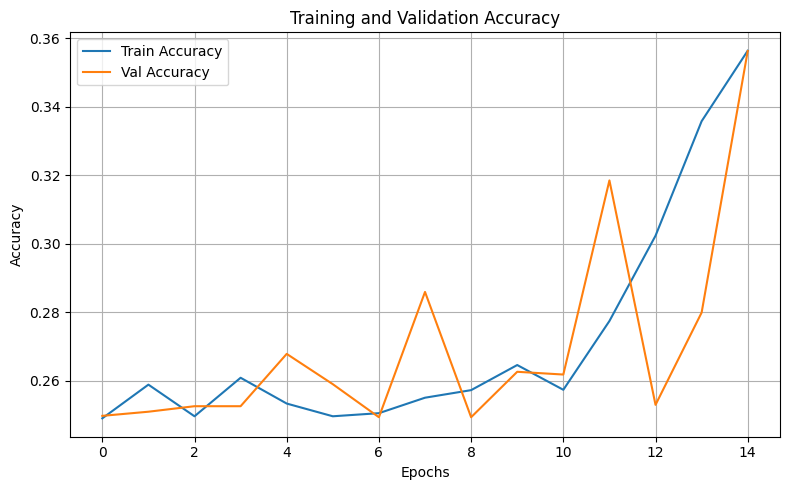

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# === 1. Set Paths ===
train_dir = 'C:\project\TRAIN'
val_dir = 'C:\project\TEST'
img_size = (224, 224)
batch_size = 32
num_classes = 4

# === 2. Data Augmentation & Generators ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# === 3. Load Pre-trained Model (without top layers) ===
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# === 4. Custom Classification Head ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# === 5. Compile Model ===
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === 6. Train the Model ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# === 7. Fine-Tune: Unfreeze top layers of base model ===
for layer in base_model.layers[-30:]:  # Unfreeze last 30 layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

# === 8. Plot Accuracy ===
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot.png")
plt.show()

# === 9. Save Model ===
model.save("hematovision_model.h5")
